In [105]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [106]:
with open('/kaggle/input/hw-data/processed_corpus.json') as f:
    corpus = json.load(f)

In [107]:
len(corpus)

100000

In [108]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [109]:
sample_text = corpus[2]

# Реализуйте разделение предложения на примеры методом CBOW

In [110]:
def cbow_split(tokens, window, pad_token='PAD'):

    splits = []

    for center_word_index in range(len(tokens)):
        left_context = [tokens[i] if i >= 0 else pad_token for i in range(center_word_index - window, center_word_index)]
        right_context = [tokens[i] if i < len(tokens) else pad_token for i in range(center_word_index + 1, center_word_index + window + 1)]
        target = tokens[center_word_index]
        splits.append((left_context, target, right_context))

    return splits

In [111]:
splits = cbow_split(sample_text, window=2)

In [112]:
' '.join(sample_text)

'притом ситуация решиться участие течение сутки заявить'

In [113]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: притом
Правый контекст: ['ситуация', 'решиться']

Левый контекст: ['PAD', 'притом']
Центральное слово: ситуация
Правый контекст: ['решиться', 'участие']

Левый контекст: ['притом', 'ситуация']
Центральное слово: решиться
Правый контекст: ['участие', 'течение']

Левый контекст: ['ситуация', 'решиться']
Центральное слово: участие
Правый контекст: ['течение', 'сутки']

Левый контекст: ['решиться', 'участие']
Центральное слово: течение
Правый контекст: ['сутки', 'заявить']

Левый контекст: ['участие', 'течение']
Центральное слово: сутки
Правый контекст: ['заявить', 'PAD']

Левый контекст: ['течение', 'сутки']
Центральное слово: заявить
Правый контекст: ['PAD', 'PAD']



In [114]:
splits

[(['PAD', 'PAD'], 'притом', ['ситуация', 'решиться']),
 (['PAD', 'притом'], 'ситуация', ['решиться', 'участие']),
 (['притом', 'ситуация'], 'решиться', ['участие', 'течение']),
 (['ситуация', 'решиться'], 'участие', ['течение', 'сутки']),
 (['решиться', 'участие'], 'течение', ['сутки', 'заявить']),
 (['участие', 'течение'], 'сутки', ['заявить', 'PAD']),
 (['течение', 'сутки'], 'заявить', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [115]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'притом', ['ситуация', 'решиться', 'участие']),
 (['PAD', 'PAD', 'притом'], 'ситуация', ['решиться', 'участие', 'течение']),
 (['PAD', 'притом', 'ситуация'], 'решиться', ['участие', 'течение', 'сутки']),
 (['притом', 'ситуация', 'решиться'],
  'участие',
  ['течение', 'сутки', 'заявить']),
 (['ситуация', 'решиться', 'участие'], 'течение', ['сутки', 'заявить', 'PAD']),
 (['решиться', 'участие', 'течение'], 'сутки', ['заявить', 'PAD', 'PAD']),
 (['участие', 'течение', 'сутки'], 'заявить', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

# Реализуйте разделение предложения на примеры методом Skipgram

In [116]:
def skipgram_split(tokens, window):
    
    splits = []

    for center_word_index in range(len(tokens)):
        left_context = [tokens[i] for i in range(center_word_index - window, center_word_index) if i >= 0]
        right_context = [tokens[i] for i in range(center_word_index + 1, center_word_index + window + 1) if i < len(tokens)]
        target = tokens[center_word_index]
        for context_word in left_context + right_context:
            splits.append((context_word, target))

    return splits

In [117]:
' '.join(sample_text)

'притом ситуация решиться участие течение сутки заявить'

In [118]:
splits = skipgram_split(sample_text, window=2)

In [119]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: ситуация
Центральное слово: притом

Контекст: решиться
Центральное слово: притом

Контекст: притом
Центральное слово: ситуация

Контекст: решиться
Центральное слово: ситуация

Контекст: участие
Центральное слово: ситуация

Контекст: притом
Центральное слово: решиться

Контекст: ситуация
Центральное слово: решиться

Контекст: участие
Центральное слово: решиться

Контекст: течение
Центральное слово: решиться

Контекст: ситуация
Центральное слово: участие

Контекст: решиться
Центральное слово: участие

Контекст: течение
Центральное слово: участие

Контекст: сутки
Центральное слово: участие

Контекст: решиться
Центральное слово: течение

Контекст: участие
Центральное слово: течение

Контекст: сутки
Центральное слово: течение

Контекст: заявить
Центральное слово: течение

Контекст: участие
Центральное слово: сутки

Контекст: течение
Центральное слово: сутки

Контекст: заявить
Центральное слово: сутки

Контекст: течение
Центральное слово: заявить

Контекст: сутки
Центральное слово:

In [120]:
skipgram_split(sample_text, window=2)

[('ситуация', 'притом'),
 ('решиться', 'притом'),
 ('притом', 'ситуация'),
 ('решиться', 'ситуация'),
 ('участие', 'ситуация'),
 ('притом', 'решиться'),
 ('ситуация', 'решиться'),
 ('участие', 'решиться'),
 ('течение', 'решиться'),
 ('ситуация', 'участие'),
 ('решиться', 'участие'),
 ('течение', 'участие'),
 ('сутки', 'участие'),
 ('решиться', 'течение'),
 ('участие', 'течение'),
 ('сутки', 'течение'),
 ('заявить', 'течение'),
 ('участие', 'сутки'),
 ('течение', 'сутки'),
 ('заявить', 'сутки'),
 ('течение', 'заявить'),
 ('сутки', 'заявить')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [121]:
skipgram_split(sample_text, window=3)

[('ситуация', 'притом'),
 ('решиться', 'притом'),
 ('участие', 'притом'),
 ('притом', 'ситуация'),
 ('решиться', 'ситуация'),
 ('участие', 'ситуация'),
 ('течение', 'ситуация'),
 ('притом', 'решиться'),
 ('ситуация', 'решиться'),
 ('участие', 'решиться'),
 ('течение', 'решиться'),
 ('сутки', 'решиться'),
 ('притом', 'участие'),
 ('ситуация', 'участие'),
 ('решиться', 'участие'),
 ('течение', 'участие'),
 ('сутки', 'участие'),
 ('заявить', 'участие'),
 ('ситуация', 'течение'),
 ('решиться', 'течение'),
 ('участие', 'течение'),
 ('сутки', 'течение'),
 ('заявить', 'течение'),
 ('решиться', 'сутки'),
 ('участие', 'сутки'),
 ('течение', 'сутки'),
 ('заявить', 'сутки'),
 ('участие', 'заявить'),
 ('течение', 'заявить'),
 ('сутки', 'заявить')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [122]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [123]:
len(word2index)

13076

In [124]:
word2index['UNK']

1

In [125]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [126]:
from torch.utils.data import Dataset, DataLoader

In [127]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [128]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.53407908, 0.49951246, 0.31348907, 0.6282297 ],
       [0.4162898 , 0.89035261, 0.78069601, 0.4888866 ],
       [0.37275177, 0.9894527 , 0.1595987 , 0.12571127],
       [0.14820856, 0.76004323, 0.79452853, 0.64846752],
       [0.22342329, 0.04633558, 0.01491697, 0.8942251 ],
       [0.12209038, 0.22448284, 0.88531968, 0.67659849],
       [0.89448213, 0.42529668, 0.35564868, 0.72758291],
       [0.04072432, 0.51960899, 0.6313634 , 0.23063907],
       [0.13380546, 0.77724873, 0.98108119, 0.52276547],
       [0.59333773, 0.01122866, 0.8080133 , 0.51033184]])

In [129]:
some_data_y

array([1, 0, 1, ..., 0, 1, 1])

In [130]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [131]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [132]:
some_dataset[5], some_dataset[467]

((array([0.12209038, 0.22448284, 0.88531968, 0.67659849]), 1),
 (array([0.85587626, 0.22209022, 0.04145321, 0.45598652]), 1))

In [133]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [134]:
for x, y in some_loader:
    break
    
len(x), x

(16,
 tensor([[0.1234, 0.3480, 0.1524, 0.8236],
         [0.6276, 0.0232, 0.2191, 0.1114],
         [0.2489, 0.9576, 0.5695, 0.9332],
         [0.2870, 0.7703, 0.5082, 0.4506],
         [0.2915, 0.2013, 0.8761, 0.4053],
         [0.4875, 0.0678, 0.2704, 0.4438],
         [0.1468, 0.6023, 0.1129, 0.9840],
         [0.1836, 0.8976, 0.0902, 0.5258],
         [0.9395, 0.8998, 0.1382, 0.5495],
         [0.4217, 0.9134, 0.6714, 0.1218],
         [0.9825, 0.4427, 0.8147, 0.7003],
         [0.8755, 0.4120, 0.2298, 0.6113],
         [0.5625, 0.1398, 0.5771, 0.5733],
         [0.7132, 0.9577, 0.0390, 0.7034],
         [0.9851, 0.4090, 0.5148, 0.7025],
         [0.8445, 0.7877, 0.4956, 0.4312]], dtype=torch.float64))

In [135]:
for x, y in some_loader:
    pass

len(x)

15

In [136]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [137]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [138]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [139]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [140]:
for x, y in toy_loader:
    break

In [141]:
x.shape

torch.Size([128, 32])

In [142]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.5341,   0.4995,   0.3135,  ...,  -4.1647,  -6.9599,  -2.7891],
        [  0.4163,   0.8904,   0.7807,  ...,  -0.6968,  -1.4854,  -4.2937],
        [  0.3728,   0.9895,   0.1596,  ...,  -0.0636, -11.0106, -12.4426],
        ...,
        [  0.8259,   0.4208,   0.9139,  ...,  -5.1933,  -0.5400,  -6.3652],
        [  0.3421,   0.1509,   0.9183,  ..., -11.3482,  -0.5115,  -2.1460],
        [  0.3353,   0.2882,   0.8658,  ...,  -7.4641,  -0.8648,  -1.2075]],
       dtype=torch.float64)

In [143]:
y

tensor([1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 2, 2, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2, 2,
        0, 1, 2, 2, 1, 2, 2, 2, 1, 0, 0, 1, 0, 0, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1,
        0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 1, 2, 2, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 2, 0, 0, 2, 1, 0, 1, 0, 2, 0, 1, 2, 2, 0, 1, 2, 1, 1, 0, 2, 2, 0,
        1, 1, 1, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 1, 2, 0, 2, 0, 1, 1, 2, 2, 1, 1,
        1, 1, 0, 2, 0, 2, 0, 0])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [144]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [145]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.1297338008880615

# Боевые датасеты

In [146]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [147]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        splits = []

        for center_word_index in range(len(tokenized_text)):
            left_context = [tokenized_text[i] for i in range(center_word_index - self.window, center_word_index) if i >= 0]
            right_context = [tokenized_text[i] for i in range(center_word_index + 1, center_word_index + self.window + 1) if i < len(tokenized_text)]
            target = tokenized_text[center_word_index]
            for context_word in left_context + right_context:
                splits.append((context_word, target))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        context, central_word = self.data[idx]

        return context, central_word

In [148]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [149]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:03<00:00, 30128.11it/s]


In [150]:
dataset[2]

(0, 1)

In [151]:
BATCH_SIZE = 1024

In [152]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [153]:
for x, y in dataset_loader:
    break

In [154]:
x[:5]

tensor([  15, 9650, 2222,  382,   55])

In [155]:
y[:5]

tensor([  16, 2042, 1555,  236,  179])

In [156]:
x.shape, y.shape

(torch.Size([1024]), torch.Size([1024]))

In [157]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [158]:
class SkipGram(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
    
    def forward(self, x):
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        return x

In [159]:
#from word2vec_utils import SkipGram

In [160]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [161]:
DEVICE = torch.device("cuda:0")

In [162]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM).to(DEVICE)

In [163]:
with torch.no_grad():
    pred = model(x.to(DEVICE))

pred.shape

torch.Size([1024, 13076])

In [164]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [165]:
def train(model, optimizer, criterion, dataset_loader, device, epochs=3):

    losses = []

    for n_epoch in range(epochs):

        try:

            progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

            for x, y in dataset_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()

                pred = model(x)

                loss = criterion(pred, y)

                loss.backward()

                optimizer.step()

                losses.append(loss.item())

                progress_bar.set_postfix(loss=np.mean(losses[-100:]))

                progress_bar.update(x.shape[0])

            progress_bar.close()

        except KeyboardInterrupt:

            progress_bar.close()
            break
    return losses

In [166]:
losses = train(model, optimizer, criterion, dataset_loader, device=DEVICE, epochs=5)

Epoch 5: 100%|██████████| 2983124/2983124 [00:20<00:00, 147389.43it/s, loss=7.54]


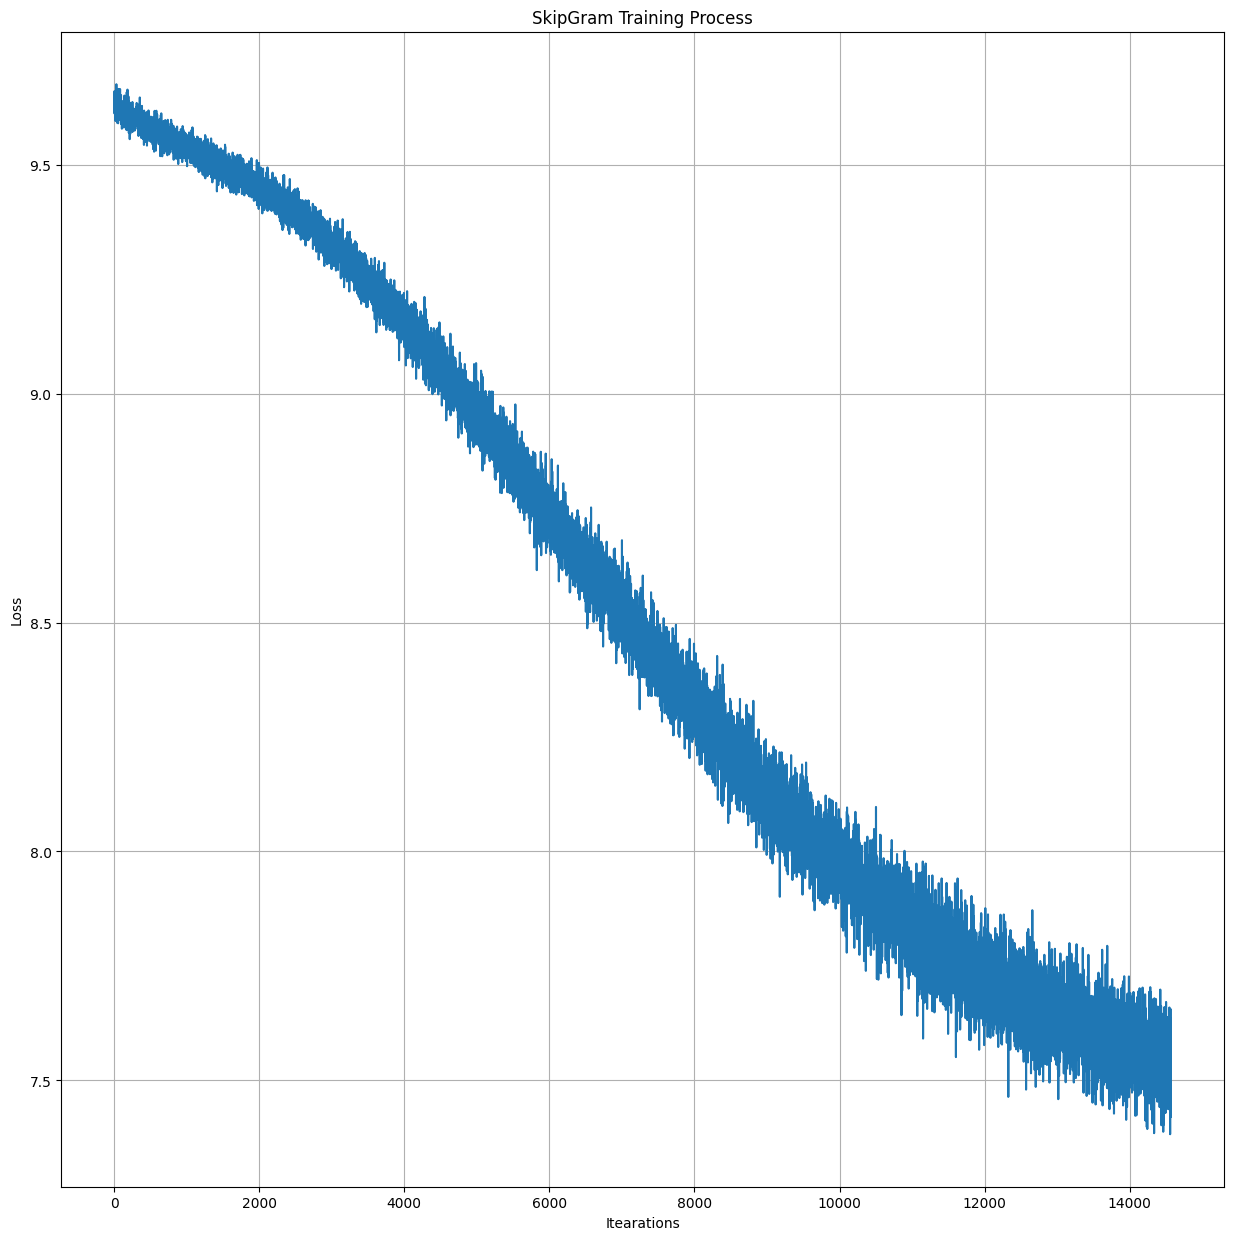

In [167]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [168]:
np.mean(losses[-1000:])

7.565590081214904

In [169]:
# # проверка, что хоть что-то выучилось
# assert np.mean(losses[-1000:]) < 7.5

In [170]:
embedding_matrix = model.cpu().in_embedding.weight.detach()

In [171]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [172]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.4515572488307953

In [173]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.5457082390785217

In [174]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.38953906297683716

In [175]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.3488527536392212

#### Нормально!

In [176]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "заява" равна -0.188'

In [177]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [178]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [179]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.001s...
[t-SNE] Computed neighbors for 13076 samples in 0.658s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

In [180]:
top_words = [a for a,_ in top_sorted_freq]

In [181]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

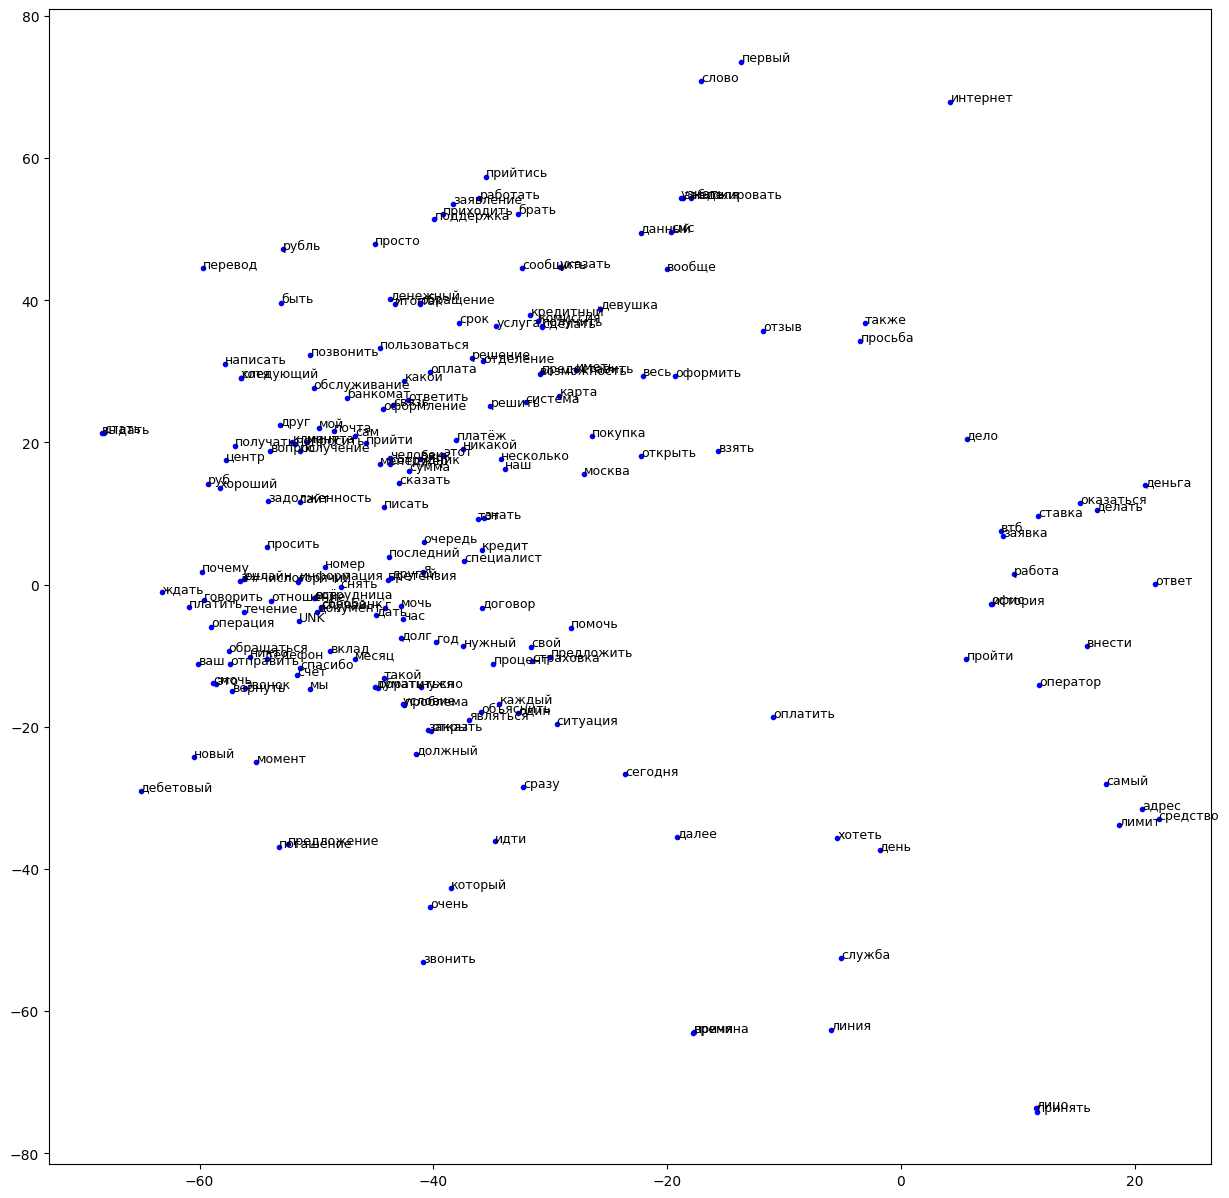

In [182]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

## Эксперименты: пробуем лучше (не вышло)

In [183]:
with open('/kaggle/input/hw-data/processed_corpus_new.json') as f:
    corpus_new = json.load(f)

In [184]:
corpus_new = corpus_new[:130000]

In [185]:
word2index_new = {}

for text in corpus_new:
    for token in text:
        if token not in word2index_new:
            word2index_new[token] = len(word2index_new)

In [186]:
dataset_new = SkipgramDataset(corpus_new, word2index_new)

100%|██████████| 130000/130000 [00:04<00:00, 27015.04it/s]


In [187]:
dataset_loader_new = DataLoader(dataset_new, shuffle=True, batch_size=BATCH_SIZE)

In [188]:
EMBEDDING_DIM = 32
EPOCHS = 10

In [189]:
model_new = SkipGram(vocab_size=len(word2index_new), embedding_dim=EMBEDDING_DIM).to(DEVICE)

In [190]:
from torch.optim.lr_scheduler import ExponentialLR

In [191]:
LEARNING_RATE = 0.01
optimizer = torch.optim.Adam(params=model_new.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
sheduler = ExponentialLR(optimizer, gamma=0.9, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [192]:
def train(model, optimizer, criterion, sheduler, dataset_loader, device, epochs=3):

    losses = []

    for n_epoch in range(epochs):

        try:

            progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

            for x, y in dataset_loader:
                
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()

                pred = model(x)

                loss = criterion(pred, y)

                loss.backward()

                optimizer.step()

                losses.append(loss.item())

                progress_bar.set_postfix(loss=np.mean(losses[-100:]))

                progress_bar.update(x.shape[0])

            progress_bar.close()
            sheduler.step()
        
        except KeyboardInterrupt:

            progress_bar.close()
            break
            
    return losses

In [193]:
losses_new = train(model_new, optimizer, criterion, sheduler, dataset_loader_new, device=DEVICE, epochs=EPOCHS)

Epoch 1: 100%|██████████| 3875168/3875168 [00:27<00:00, 141717.01it/s, loss=6.82]


Adjusting learning rate of group 0 to 9.0000e-03.


Epoch 2: 100%|██████████| 3875168/3875168 [00:27<00:00, 140434.78it/s, loss=6.73]


Adjusting learning rate of group 0 to 8.1000e-03.


Epoch 3: 100%|██████████| 3875168/3875168 [00:27<00:00, 140934.46it/s, loss=6.68]


Adjusting learning rate of group 0 to 7.2900e-03.


Epoch 4: 100%|██████████| 3875168/3875168 [00:27<00:00, 142874.23it/s, loss=6.64]


Adjusting learning rate of group 0 to 6.5610e-03.


Epoch 5: 100%|██████████| 3875168/3875168 [00:27<00:00, 141023.10it/s, loss=6.61]


Adjusting learning rate of group 0 to 5.9049e-03.


Epoch 6: 100%|██████████| 3875168/3875168 [00:27<00:00, 139793.73it/s, loss=6.6] 


Adjusting learning rate of group 0 to 5.3144e-03.


Epoch 7: 100%|██████████| 3875168/3875168 [00:27<00:00, 141475.24it/s, loss=6.59]


Adjusting learning rate of group 0 to 4.7830e-03.


Epoch 8: 100%|██████████| 3875168/3875168 [00:27<00:00, 141461.33it/s, loss=6.59]


Adjusting learning rate of group 0 to 4.3047e-03.


Epoch 9: 100%|██████████| 3875168/3875168 [00:27<00:00, 141740.54it/s, loss=6.57]


Adjusting learning rate of group 0 to 3.8742e-03.


Epoch 10: 100%|██████████| 3875168/3875168 [00:26<00:00, 143575.19it/s, loss=6.54]

Adjusting learning rate of group 0 to 3.4868e-03.


In [194]:
embedding_matrix_new = model_new.cpu().in_embedding.weight.detach()

In [195]:
np.mean(losses_new[-1000:])

6.553347085952759

## Оценка качества эмбеддингов

In [196]:
import pandas as pd

In [197]:
df = pd.read_csv('/kaggle/input/hw-data/ru_simlex965_tagged.tsv', delimiter='\t')

In [198]:
df.head(3)

,# Word1,Word2,Average Score
0,авария_NOUN,бедствие_NOUN,6.15
1,август_NOUN,месяц_NOUN,2.85
2,авиация_NOUN,полет_NOUN,6.77


In [199]:
df['# Word1'] = df['# Word1'].apply(lambda x: x.split('_')[0])
df['Word2'] = df['Word2'].apply(lambda x: x.split('_')[0])

In [200]:
# Чтобы нормализовать значения в наборе данных между 0 и 1, вы можете использовать следующую формулу:

# z i = (x i – мин(х)) / (макс(х) – мин(х))

In [201]:
df['Average Score'] = (df['Average Score'] - df['Average Score'].min()) / (df['Average Score'].max() - df['Average Score'].min())

In [202]:
df.head(3)

,# Word1,Word2,Average Score
0,авария,бедствие,0.615
1,август,месяц,0.285
2,авиация,полет,0.677


In [203]:
def eval_embs(embedding_matrix, word2index, df):
    cossim = [cos_sim(embedding_matrix, word2index, df['# Word1'][i], df['Word2'][i])
              if df['# Word1'][i] in word2index and df['Word2'][i] in word2index else None
              for i in range(len(df))]
    return np.array(cossim)

In [204]:
y_true = np.array(df['Average Score'].tolist())

y_pred_initial = eval_embs(embedding_matrix, word2index, df)
y_pred_new = eval_embs(embedding_matrix_new, word2index_new, df)

In [205]:
y_true_model_one, y_pred_model_one = zip(*[(y_true[i], y_pred_initial[i]) for i, val in enumerate(y_pred_initial) if val is not None]) 
y_true_model_two, y_pred_model_two = zip(*[(y_true[i], y_pred_new[i]) for i, val in enumerate(y_pred_new) if val is not None])

In [206]:
from sklearn.metrics import mean_squared_error

In [207]:
mean_squared_error(y_true_model_one, y_pred_model_one)

0.23034606412781922

In [208]:
mean_squared_error(y_true_model_two, y_pred_model_two)

0.10582584927868537

Лучше сделать не получилось, победила первая модель.

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов